<h1>DSCI 552 Homework 5</h1>

Name: Mike Gee\
Github Username: mpg05883\
USC ID: 6845465208\
Due date: ```June 24th, 2024 at 11:59pm```

**Table of contents**<a id='toc0_'></a>    
- [Decision Trees as Interpretable Models](#toc1_1_)    
    - [(a) Obtain Data](#toc1_1_1_)    
    - [(b) Build a decision tree](#toc1_1_2_)    
    - [(c) Convert the decision rules](#toc1_1_3_)    
    - [(d) Interpretability](#toc1_1_4_)    
      - [Prune the decision tree using cost-complexity pruning.](#toc1_1_4_1_)    
      - [Generate a new set of decision rules.](#toc1_1_4_2_)    
  - [The LASSO and Boosting for Regression](#toc1_2_)    
    - [(a) Obtain Data](#toc1_2_1_)    
    - [(b) Missing values](#toc1_2_2_)    
    - [(c) Plot a correlation matrix](#toc1_2_3_)    
    - [(d) Calculate the Coefficient of Variation CV](#toc1_2_4_)    
    - [(e) Scatter plots and box plots for highest CV features](#toc1_2_5_)    
    - [(f) Fit a linear model](#toc1_2_6_)    
    - [(g) Fit a ridge regression model](#toc1_2_7_)    
    - [(h) Fit a LASSO model](#toc1_2_8_)    
    - [(i) Fit a PCR model](#toc1_2_9_)    
    - [(j) Fit a boosting tree](#toc1_2_10_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Decision Trees as Interpretable Models](#toc0_)

Import packages

In [48]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, Markdown, HTML, Math
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.impute import SimpleImputer
from scipy.stats import variation
import operator
import math
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
import xgboost as xgb 

### <a id='toc1_1_1_'></a>[(a) Obtain Data](#toc0_)

Download the Accute Inflamations data from https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations.

Features:
- Temperature of patient  { 35°C - 42°C }
- Occurrence of nausea  { yes, no }	
- Lumbar pain  { yes, no }	
- Urine pushing (continuous need for urination)  { yes, no }	
- Micturition pains  { yes, no }	
- Burning of urethra, itch, swelling of urethra outlet  { yes, no }	

Classes:
- Inflammation of urinary bladder  { yes, no }
- Nephritis of renal pelvis origin { yes, no }	

In [49]:
features = ['temperature',
            'nausea',
            'lumbar_pain',
            'urine_pushing',
            'micturition_pains',
            'burning_urethra',]

classes = ['bladder_inflammation',
            'nephritis',]

# read in accute inflamations dataset
df = pd.read_csv(filepath_or_buffer='../data/diagnosis.data',
    sep='\t',   
    header=None,
    encoding='utf-16',
    decimal=',',)

# define dataframe column labels
df.columns = features + classes

# replace all instances of 'yes' with 1 and all instances of 'no' with 0
df.replace(to_replace=['yes', 'no'], value=[1, 0], inplace=True,)

# display first five rows
df.head()

,temperature,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_urethra,bladder_inflammation,nephritis
0,35.5,0,1,0,0,0,0,0
1,35.9,0,0,1,1,1,1,0
2,35.9,0,1,0,0,0,0,0
3,36.0,0,0,1,1,1,1,0
4,36.0,0,1,0,0,0,0,0


In [50]:
assert(df.shape == (120, 8)) 

### <a id='toc1_1_2_'></a>[(b) Build a decision tree](#toc0_)

Build a decision tree on the whole data set and plot it.

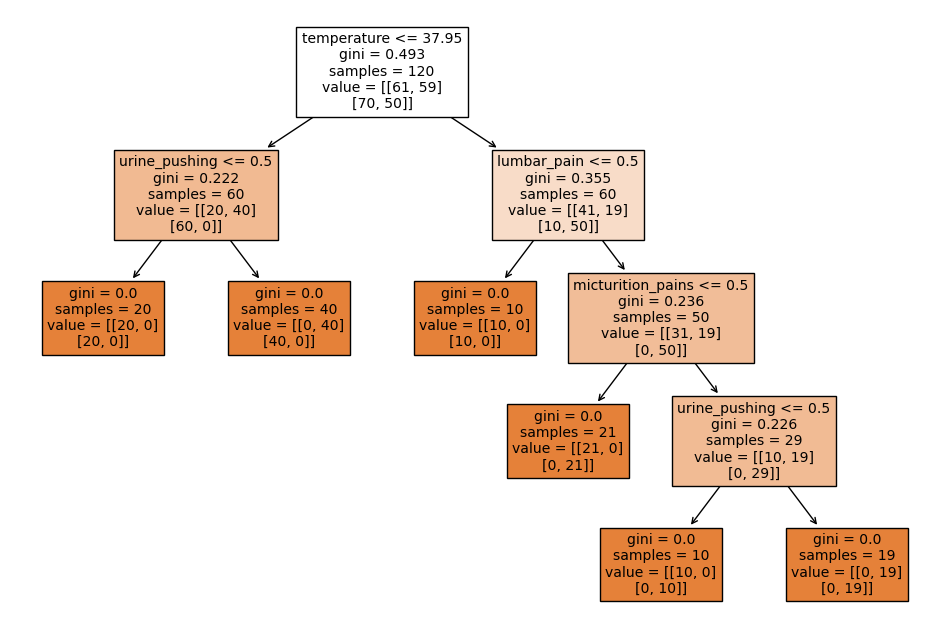

In [51]:
# split dataframe into features and responses
X, y = df.iloc[:, :-2], df.iloc[:, -2:]

# create decision tree classifier and fit it to entire dataset
clf = tree.DecisionTreeClassifier().fit(X, y)

# plot decision tree
plt.figure(figsize=(12, 8))
tree.plot_tree(clf, filled=True, feature_names=features, class_names=classes)
plt.show()

### <a id='toc1_1_3_'></a>[(c) Convert the decision rules](#toc0_)

Convert the decision rules into a set of IF-THEN rules.

- Get ```tree_to_code``` function from [KD nuggets.](https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html)

In [52]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
	"""
	Outputs a decision tree model as a Python function
	
	Parameters:
	-----------
	tree: decision tree model
		The decision tree to represent as a function
	feature_names: list
		The feature names of the dataset used for building the decision tree
	"""

	tree_ = tree.tree_
	feature_name = [
		feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
		for i in tree_.feature
	]
	print("def tree({}):".format(", ".join(feature_names)))

	def recurse(node, depth):
		indent = "  " * depth
		if tree_.feature[node] != _tree.TREE_UNDEFINED:
			name = feature_name[node]
			threshold = tree_.threshold[node]
			print("{}if {} <= {}:".format(indent, name, threshold))
			recurse(tree_.children_left[node], depth + 1)
			print("{}else:  # if {} > {}".format(indent, name, threshold))
			recurse(tree_.children_right[node], depth + 1)
		else:
			print("{}return {}".format(indent, tree_.value[node]))

	recurse(0, 1)

- Generate IF-THEN ruleset.

In [53]:
tree_to_code(tree=clf, feature_names=features)

def tree(temperature, nausea, lumbar_pain, urine_pushing, micturition_pains, burning_urethra):
  if temperature <= 37.95000076293945:
    if urine_pushing <= 0.5:
      return [[20.  0.]
 [20.  0.]]
    else:  # if urine_pushing > 0.5
      return [[ 0. 40.]
 [40.  0.]]
  else:  # if temperature > 37.95000076293945
    if lumbar_pain <= 0.5:
      return [[10.  0.]
 [10.  0.]]
    else:  # if lumbar_pain > 0.5
      if micturition_pains <= 0.5:
        return [[21.  0.]
 [ 0. 21.]]
      else:  # if micturition_pains > 0.5
        if urine_pushing <= 0.5:
          return [[10.  0.]
 [ 0. 10.]]
        else:  # if urine_pushing > 0.5
          return [[ 0. 19.]
 [ 0. 19.]]


### <a id='toc1_1_4_'></a>[(d) Interpretability](#toc0_)

Use cost-complexity pruning to find a minimal decision tree and a set of decision
rules with high interpretability.

#### <a id='toc1_1_4_1_'></a>[Prune the decision tree using cost-complexity pruning](#toc0_)

1) Build a decision tree for each $\alpha$.

In [54]:
"""
I referenced Scikit Learn's example for cost complexity pruning:
https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html
"""
# get cost complexity pruning path
path = clf.cost_complexity_pruning_path(X=X, y=y)

# get effective alphas and corresponding total leaf impurities
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# store decision trees with different alphas
clfs = []

# fit a decision tree to each alpha 
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha).fit(X, y)
    clfs.append(clf)
    
# remove decision tree with only one node and its corresponding alpha
clfs, ccp_alphas = clfs[:-1], ccp_alphas[:-1]

2) Choose $\alpha$ using K-fold cross-validation.

In [55]:
"""
I referenced this article for how to use GridSearchCV:
https://www.analyticsvidhya.com/blog/2021/06/tune-hyperparameters-with-gridsearchcv/
"""
# initialize parameter values for grid search
param_grid = {'ccp_alpha' : ccp_alphas}

# perform cross-validation to find best alpha
clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5).fit(X, y)

# get alpha and corresponding decision tree chosen from cross-validation
alpha = clf.best_params_['ccp_alpha']
clf = clfs[np.where(ccp_alphas == alpha)[0][0]]

# display alpha
display(Math(r'\alpha = ' + str(alpha)))

<IPython.core.display.Math object>

- Display pruned decison tree.

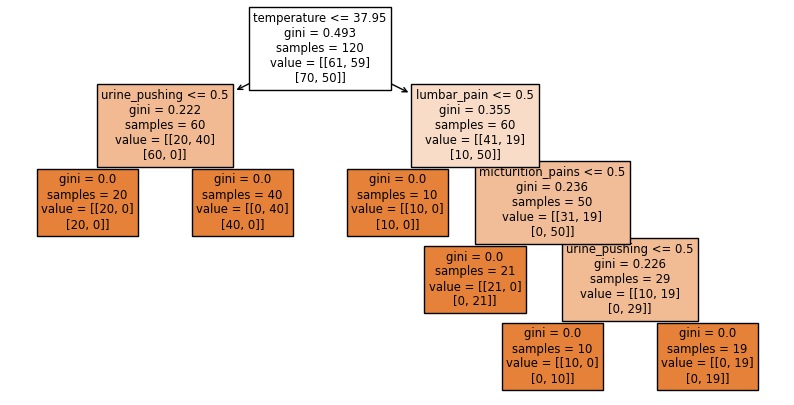

In [56]:
plt.figure(figsize=(10, 5))
tree.plot_tree(clf, filled=True, feature_names=features, class_names=classes)
plt.show()

#### <a id='toc1_1_4_2_'></a>[Generate a new set of decision rules](#toc0_)

In [57]:
tree_to_code(tree=clf, feature_names=features)

def tree(temperature, nausea, lumbar_pain, urine_pushing, micturition_pains, burning_urethra):
  if temperature <= 37.95000076293945:
    if urine_pushing <= 0.5:
      return [[20.  0.]
 [20.  0.]]
    else:  # if urine_pushing > 0.5
      return [[ 0. 40.]
 [40.  0.]]
  else:  # if temperature > 37.95000076293945
    if lumbar_pain <= 0.5:
      return [[10.  0.]
 [10.  0.]]
    else:  # if lumbar_pain > 0.5
      if micturition_pains <= 0.5:
        return [[21.  0.]
 [ 0. 21.]]
      else:  # if micturition_pains > 0.5
        if urine_pushing <= 0.5:
          return [[10.  0.]
 [ 0. 10.]]
        else:  # if urine_pushing > 0.5
          return [[ 0. 19.]
 [ 0. 19.]]


## <a id='toc1_2_'></a>[The LASSO and Boosting for Regression](#toc0_)

### <a id='toc1_2_1_'></a>[(a) Obtain Data](#toc0_)

Download the Communities and Crime data from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime.

- Read column labels from ```communities.names```.

In [58]:
# store feature names and class names
column_labels = []

# read communities.names to extract column labels
file = open('../data/communities.names', 'r',)
for line in file:
    # stop iterating once there are 128 column labels
    if len(column_labels) == 128:
        break
    
    # parse the lines that contain '@attribute' to extract column labels
    if '@attribute' in line:
        column_labels.append(line.split()[1])

- Read data.

In [59]:
df = pd.read_csv(filepath_or_buffer='../data/communities.data',
                header=None,
                sep=',',)
df.columns = column_labels
df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,?,?,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,?,?,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,?,?,?,?,0.00,?,0.67
2,24,?,?,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,?,?,?,?,0.00,?,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,?,?,?,?,0.00,?,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,?,?,?,?,0.00,?,0.03


In [60]:
assert(df.shape == (1994, 128)) 

### <a id='toc1_2_2_'></a>[(b) Missing values](#toc0_)

The data set has missing values. Use a data imputation technique to deal with the missing values in the data set.
- The first five features are nonpredictive — ignore those features.

In [61]:
# remove nonpredictive features
df = df.iloc[:, 5:]

# initialize univariate imputer
imp = SimpleImputer(missing_values='?', strategy='most_frequent',)

# impute missing values using mode bc there's missing text and numeric data
df[df.columns] = imp.fit_transform(df)

- Display imputed dataframe without nonpredictive features.

In [62]:
df.head()

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,0.19,0.33,0.02,0.9,0.12,0.17,0.34,0.47,0.29,0.32,...,0.12,0.26,0.2,0.06,0.04,0.9,0.5,0.32,0.14,0.2
1,0.0,0.16,0.12,0.74,0.45,0.07,0.26,0.59,0.35,0.27,...,0.02,0.12,0.45,0.02,0.02,0.74,0,0.0,0.12,0.67
2,0.0,0.42,0.49,0.56,0.17,0.04,0.39,0.47,0.28,0.32,...,0.01,0.21,0.02,0.02,0.02,0.74,0,0.0,0.12,0.43
3,0.04,0.77,1.0,0.08,0.12,0.1,0.51,0.5,0.34,0.21,...,0.02,0.39,0.28,0.02,0.02,0.74,0,0.0,0.12,0.12
4,0.01,0.55,0.02,0.95,0.09,0.05,0.38,0.38,0.23,0.36,...,0.04,0.09,0.02,0.02,0.02,0.74,0,0.0,0.12,0.03


### <a id='toc1_2_3_'></a>[(c) Plot a correlation matrix](#toc0_)

Plot a correlation matrix for the features in the data set.

In [63]:
"""
I used code from this Stack Overflow post to make the correlation matrix:
https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas
"""
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

### <a id='toc1_2_4_'></a>[(d) Calculate the Coefficient of Variation CV](#toc0_)

Calculate the Coefficient of Variation $CV$ for each feature, where $CV = \frac{s}{m}$, in where $s$ is sample standard deviation and $m$ is sample mean.

In [64]:
# feature : CV
coeffs_of_var = {}

# calculate CV for each feature 
for col in df.columns:
    coeffs_of_var[f'{col}_CV'] = variation(pd.to_numeric(df[col]))

# display each feature's CV
HTML(pd.DataFrame(data=[coeffs_of_var]).to_html(index=False))

population_CV,householdsize_CV,racepctblack_CV,racePctWhite_CV,racePctAsian_CV,racePctHisp_CV,agePct12t21_CV,agePct12t29_CV,agePct16t24_CV,agePct65up_CV,numbUrban_CV,pctUrban_CV,medIncome_CV,pctWWage_CV,pctWFarmSelf_CV,pctWInvInc_CV,pctWSocSec_CV,pctWPubAsst_CV,pctWRetire_CV,medFamInc_CV,perCapInc_CV,whitePerCap_CV,blackPerCap_CV,indianPerCap_CV,AsianPerCap_CV,OtherPerCap_CV,HispPerCap_CV,NumUnderPov_CV,PctPopUnderPov_CV,PctLess9thGrade_CV,PctNotHSGrad_CV,PctBSorMore_CV,PctUnemployed_CV,PctEmploy_CV,PctEmplManu_CV,PctEmplProfServ_CV,PctOccupManu_CV,PctOccupMgmtProf_CV,MalePctDivorce_CV,MalePctNevMarr_CV,FemalePctDiv_CV,TotalPctDiv_CV,PersPerFam_CV,PctFam2Par_CV,PctKids2Par_CV,PctYoungKids2Par_CV,PctTeen2Par_CV,PctWorkMomYoungKids_CV,PctWorkMom_CV,NumIlleg_CV,PctIlleg_CV,NumImmig_CV,PctImmigRecent_CV,PctImmigRec5_CV,PctImmigRec8_CV,PctImmigRec10_CV,PctRecentImmig_CV,PctRecImmig5_CV,PctRecImmig8_CV,PctRecImmig10_CV,PctSpeakEnglOnly_CV,PctNotSpeakEnglWell_CV,PctLargHouseFam_CV,PctLargHouseOccup_CV,PersPerOccupHous_CV,PersPerOwnOccHous_CV,PersPerRentOccHous_CV,PctPersOwnOccup_CV,PctPersDenseHous_CV,PctHousLess3BR_CV,MedNumBR_CV,HousVacant_CV,PctHousOccup_CV,PctHousOwnOcc_CV,PctVacantBoarded_CV,PctVacMore6Mos_CV,MedYrHousBuilt_CV,PctHousNoPhone_CV,PctWOFullPlumb_CV,OwnOccLowQuart_CV,OwnOccMedVal_CV,OwnOccHiQuart_CV,RentLowQ_CV,RentMedian_CV,RentHighQ_CV,MedRent_CV,MedRentPctHousInc_CV,MedOwnCostPctInc_CV,MedOwnCostPctIncNoMtg_CV,NumInShelters_CV,NumStreet_CV,PctForeignBorn_CV,PctBornSameState_CV,PctSameHouse85_CV,PctSameCity85_CV,PctSameState85_CV,LemasSwornFT_CV,LemasSwFTPerPop_CV,LemasSwFTFieldOps_CV,LemasSwFTFieldPerPop_CV,LemasTotalReq_CV,LemasTotReqPerPop_CV,PolicReqPerOffic_CV,PolicPerPop_CV,RacialMatchCommPol_CV,PctPolicWhite_CV,PctPolicBlack_CV,PctPolicHisp_CV,PctPolicAsian_CV,PctPolicMinor_CV,OfficAssgnDrugUnits_CV,NumKindsDrugsSeiz_CV,PolicAveOTWorked_CV,LandArea_CV,PopDens_CV,PctUsePubTrans_CV,PolicCars_CV,PolicOperBudg_CV,LemasPctPolicOnPatr_CV,LemasGangUnitDeploy_CV,LemasPctOfficDrugUn_CV,PolicBudgPerPop_CV,ViolentCrimesPerPop_CV
2.20295,0.35321,1.410567,0.3237,1.358821,1.613873,0.365748,0.29062,0.495036,0.423336,2.001242,0.638689,0.579608,0.327628,0.699855,0.35915,0.36842,0.698855,0.349551,0.5276,0.545497,0.507425,0.589321,0.809482,0.606042,0.671187,0.473841,2.304392,0.753791,0.675431,0.528154,0.578256,0.555993,0.34724,0.510452,0.398126,0.508334,0.422,0.395484,0.40371,0.359183,0.371375,0.316875,0.330528,0.332393,0.329343,0.328469,0.336164,0.332639,2.993446,0.919572,2.89977,0.68403,0.584744,0.504783,0.455552,1.299774,1.297306,1.280912,1.283712,0.288601,1.458701,0.734351,0.756919,0.366822,0.319327,0.468336,0.350228,1.126917,0.348283,0.810684,1.958288,0.269579,0.337456,1.064475,0.43601,0.470293,0.917981,0.848531,0.847668,0.878529,0.874514,0.633028,0.561743,0.586867,0.555453,0.345743,0.416287,0.476814,3.484607,4.406597,1.072022,0.33549,0.338859,0.320025,0.304163,2.08019,0.648419,0.058246,0.465988,2.177024,0.468904,0.35895,0.648483,0.126025,0.122666,3.522377,4.293965,5.446469,1.134108,1.362546,0.143191,0.479902,1.677611,0.871968,1.416317,2.343986,2.054401,0.118324,3.24663,2.554625,0.540148,0.978769


### <a id='toc1_2_5_'></a>[(e) Scatter plots and box plots for highest CV features](#toc0_)

Pick $\left \lfloor {\sqrt{128}}\right \rfloor $ features with highest CV and make scatter plots and box plots for them.

- Identify $\left \lfloor {\sqrt{128}}\right \rfloor $ features with highest CV.

In [65]:
"""
I used the example in this Stack Overflow post to sort my dict my values:
https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
"""
# sort key-val pairs in coeffs_of_var by value and convert into list of tuples
sorted_coeff_of_var = sorted(coeffs_of_var.items(),
                            key=operator.itemgetter(1),
                            reverse=True,)

# get 11 features with highest CV
sorted_coeff_of_var = sorted_coeff_of_var[:int(math.sqrt(math.floor(128)))]

# declare df to hold scatter matrix features
scatter_df = pd.DataFrame(data=None)

# append columns from original dataframe to scatter dataframe
for pair in sorted_coeff_of_var:
    column_label = pair[0].replace('_CV', '')
    scatter_df[column_label] = pd.to_numeric(df[column_label])

# display scatter matrix features
scatter_df.head()

,PctPolicAsian,NumStreet,PctPolicHisp,PctPolicBlack,NumInShelters,LemasGangUnitDeploy,NumIlleg,NumImmig,LemasPctOfficDrugUn,PolicCars,NumUnderPov
0,0.1,0.0,0.07,0.03,0.04,0.5,0.04,0.03,0.32,0.06,0.08
1,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.01,0.00,0.02,0.01
2,0.0,0.0,0.00,0.00,0.00,0.0,0.01,0.00,0.00,0.02,0.01
3,0.0,0.0,0.00,0.00,0.00,0.0,0.03,0.02,0.00,0.02,0.01
4,0.0,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.02,0.00


- Make scatter matrix.

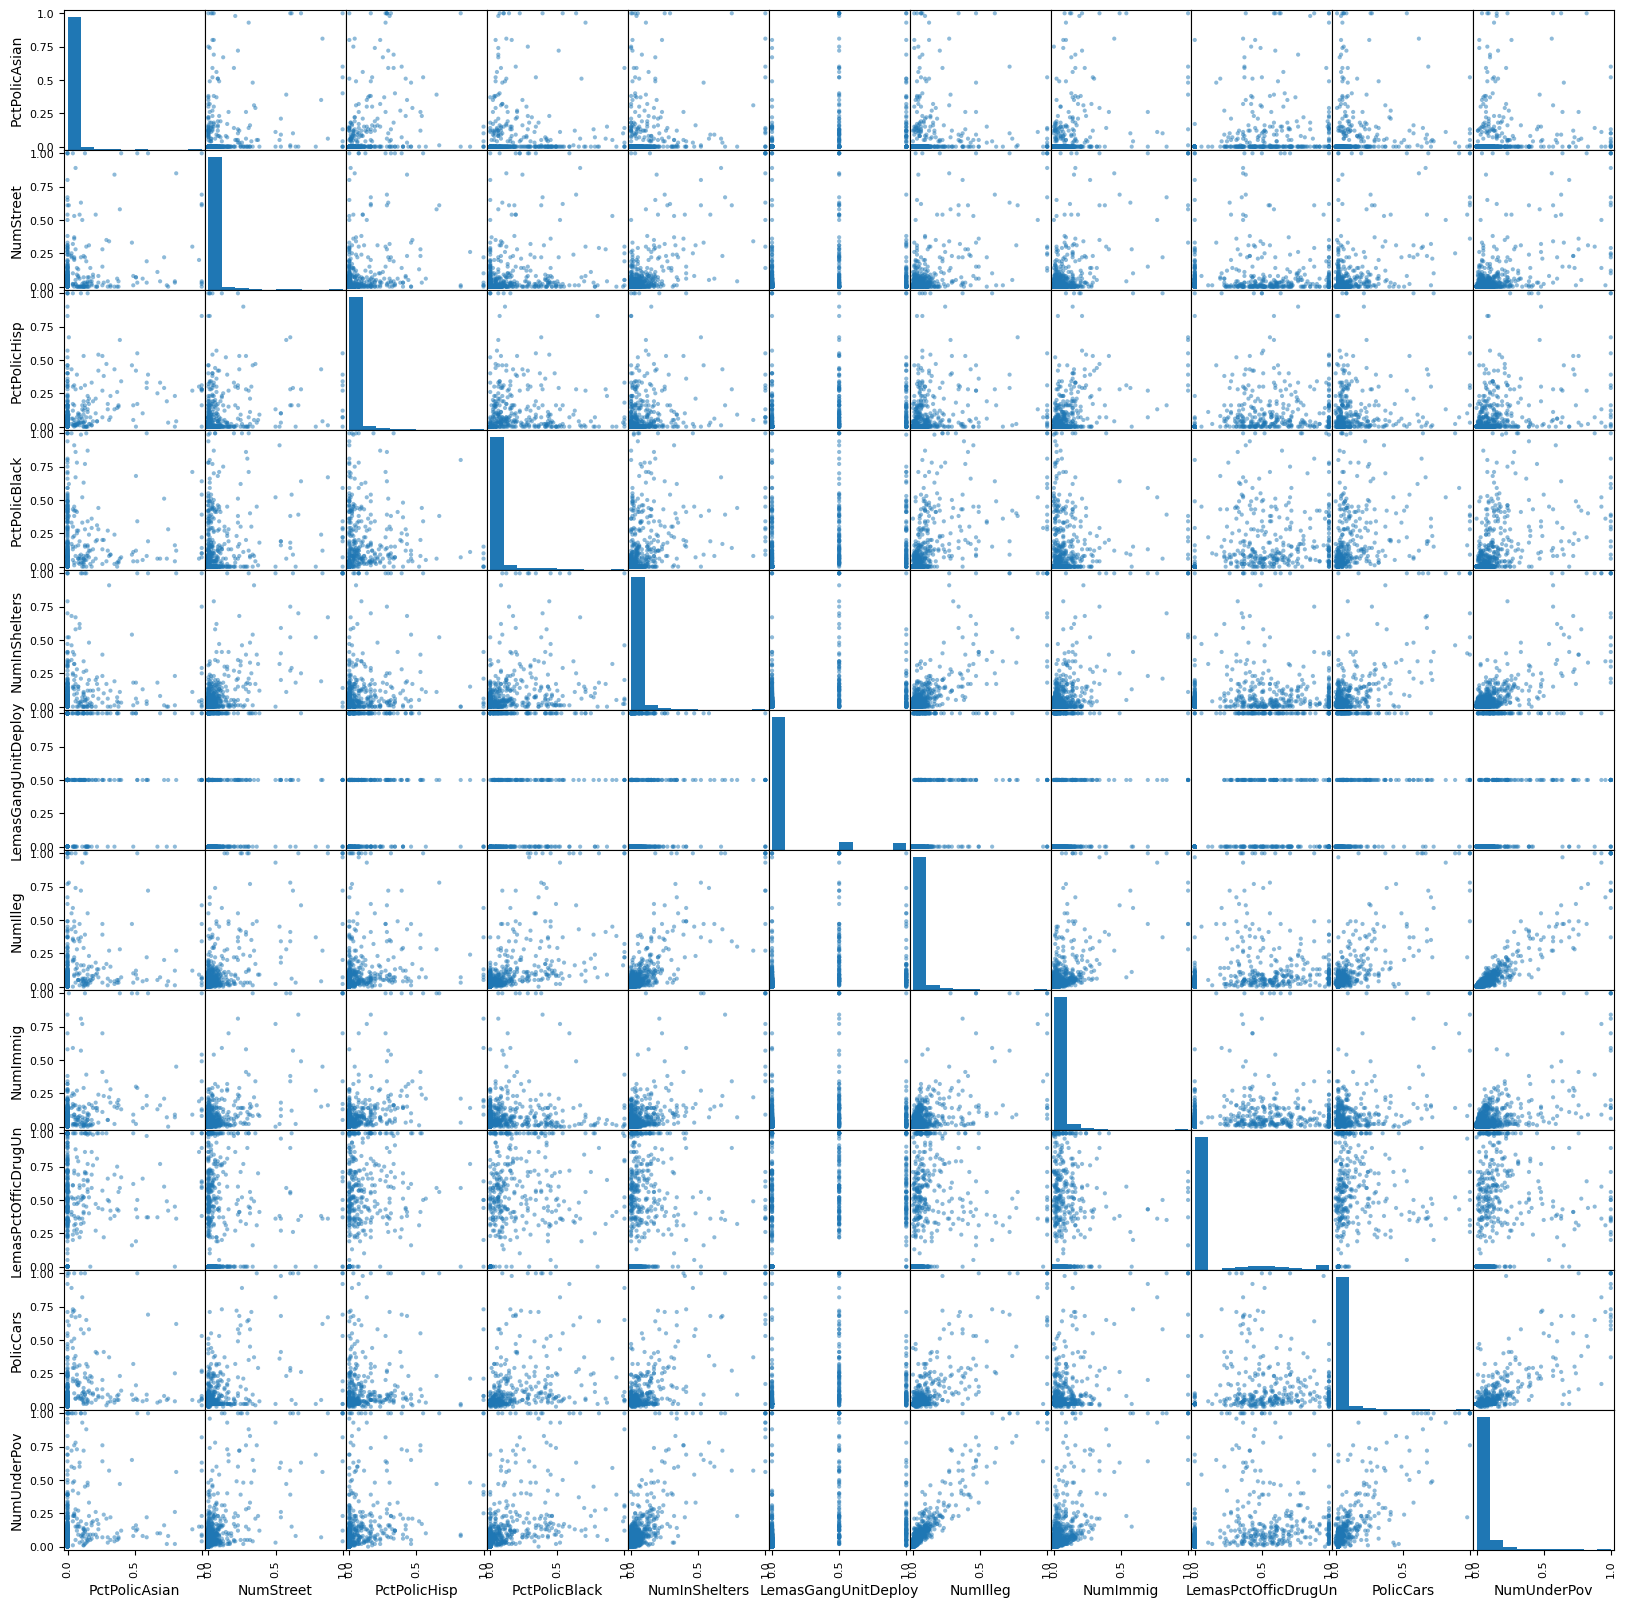

In [66]:
pd.plotting.scatter_matrix(frame=scatter_df, figsize=[20, 20]);

- Make boxplots.

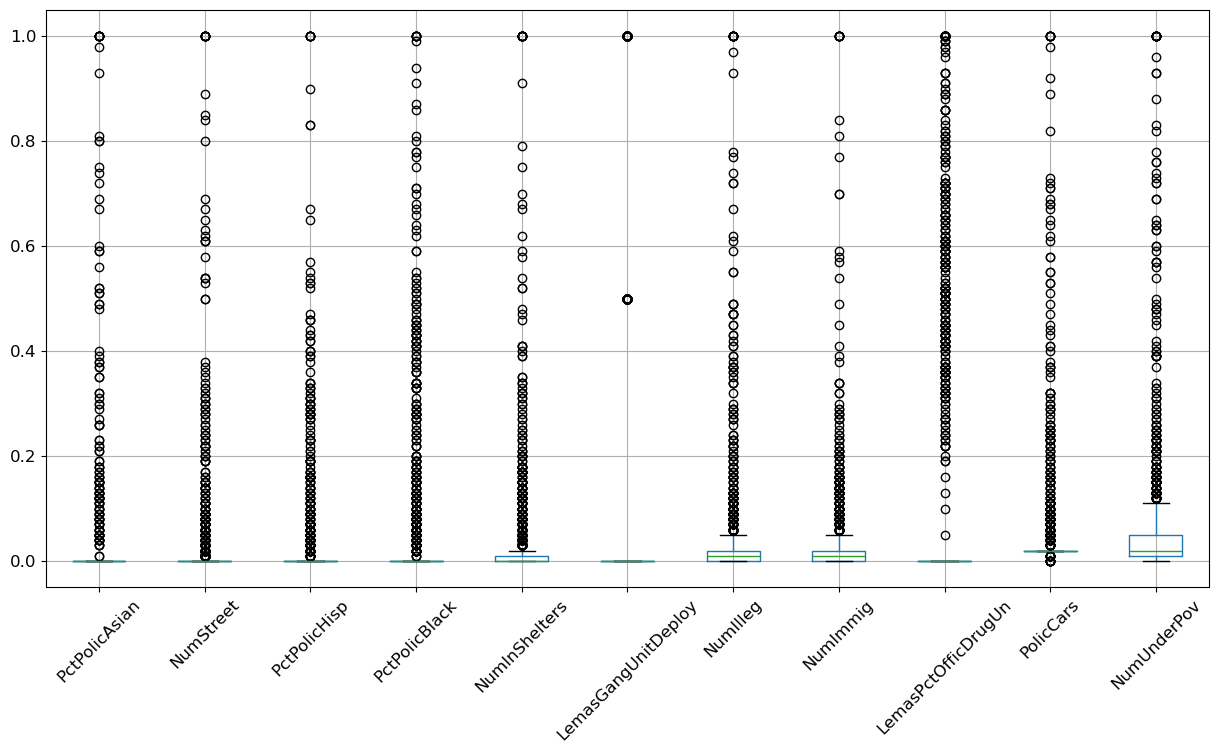

In [67]:
boxplot = scatter_df.boxplot(rot=45, figsize=(15, 7.5), fontsize=12)

Can you draw conclusions about significance of those features, just by the scatter plots?


- Just by looking at the scatterplots, there doesn't seem to be any significant amount of correlation between features.

### <a id='toc1_2_6_'></a>[(f) Fit a linear model](#toc0_)

Fit a linear model using least squares to the training set and report the test error.

- Use the first 1495 rows of data as the training set and the rest as the test set.

In [68]:
training_set, test_set = df.iloc[:1495], df.iloc[1495:]

# split training set into features and response
X_train, y_train = training_set.iloc[:, :-1], training_set.iloc[:, -1]

# split test set into features and response
X_test, y_test = test_set.iloc[:, :-1], test_set.iloc[:, -1]

In [69]:
assert(training_set.shape == (1495, 123))
assert(test_set.shape == (499, 123))

-  Fit linear model to training set and report test error.

In [70]:
# fit linear model to training set
reg = LinearRegression(fit_intercept=False).fit(X=X_train, y=y_train)

# predict response for test data
y_pred = reg.predict(X=X_test)

# calculate and display MSE
mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
display(Markdown(f'Linear regression test error = {mse:.4f}'))

Linear regression test error = 0.0181

### <a id='toc1_2_7_'></a>[(g) Fit a ridge regression model](#toc0_)

Fit a ridge regression model on the training set, with $λ$ chosen by cross-validation.

- Helper function to find $\lambda$ using 5-fold cross-validation.

In [71]:
def find_alpha(estimator) -> float:
    # generate potential alphas
    grid_params = {'alpha' : np.geomspace(1e-2, 1e+4, num=7)}

    # perform cross-validation and return chosen alpha
    clf = GridSearchCV(estimator, grid_params, cv=5).fit(X_train, y_train)
    return clf.best_params_['alpha']

- Choose $\lambda$ using cross-validation.

In [72]:
alpha = find_alpha(Ridge())
display(Markdown(f'$\lambda$ = {alpha:.2f}'))

$\lambda$ = 1.00

- Fit a ridge regression model on the training set and report the test error obtained.

In [73]:
# fit ridge regression model to training set with alpha from cross-validation
clf = Ridge(alpha=alpha).fit(X_train, y_train)

# predict response for test set
y_pred = clf.predict(X_test)

# calculate and display MSE
mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
display(Markdown(f'Ridge regression test error = {mse:.4f}'))

Ridge regression test error = 0.0176

### <a id='toc1_2_8_'></a>[(h) Fit a LASSO model](#toc0_)

Fit a LASSO model on the training set, with $λ$ chosen by cross-validation.

- Choose $\lambda$ using cross-validation.

In [74]:
alpha = find_alpha(Lasso())
display(Markdown(f'$\lambda$ = {alpha}'))

$\lambda$ = 0.01

- Fit a LASSO model on the training set and report the test error obtained.

In [75]:
# fit LASSO model to training set using alpha from cross-validation
clf = Lasso(alpha=alpha).fit(X_train, y_train)

# predict response for test set
y_pred = clf.predict(X_test)

# calculate and display unstandardized MSE
mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
display(Markdown(f'Unstandardized LASSO test error = {mse:.4f}'))

Unstandardized LASSO test error = 0.0209

Repeat with standardized features.

In [76]:
# initialize standard scaler
scaler = StandardScaler()

# fit and transform features
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_train = pd.DataFrame(scaled_X_train, columns=X_train.columns)
scaled_X_test = scaler.fit_transform(X_test)
scaled_X_test = pd.DataFrame(scaled_X_test, columns=X_test.columns)

# fit LASSO model on scaled training set
clf = Lasso(alpha=alpha).fit(scaled_X_train, y_train)

# predict response for scaled test set
y_pred = clf.predict(scaled_X_test)

# calculate and display standardized MSE
standardized_mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
display(Markdown(f'Standardized LASSO test error = {standardized_mse:.4f}'))

Standardized LASSO test error = 0.0174

Report the test error for both cases and compare them.

In [77]:
display(Markdown(f'- Unstadardized test error = {mse:.4f}'))
display(Markdown(f'- Standardized test error = {standardized_mse:.4f}'))
display(Markdown(f'- Standardized test error is less than unstandardized test error'))

- Unstadardized test error = 0.0209

- Standardized test error = 0.0174

- Standardized test error is less than unstandardized test error

### <a id='toc1_2_9_'></a>[(i) Fit a PCR model](#toc0_)

Fit a PCR model on the training set, with $M$ (the number of principal components) chosen by cross-validation. 

- Plot $MSE$ vs $M$.

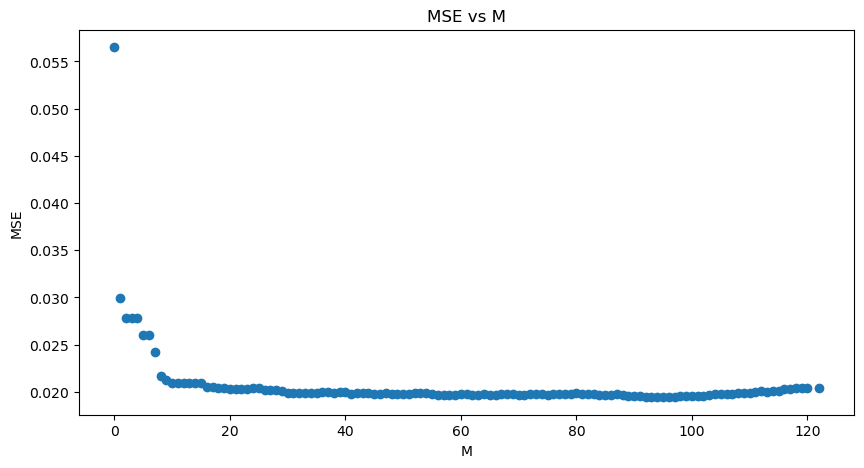

In [78]:
"""
I followed this example to generate the MSE vs M plot:
https://www.science.smith.edu/~jcrouser/SDS293/labs/lab11-py.html
"""
# scale and transform features
pca = PCA()
scaled_X_train = pca.fit_transform(scale(X_train))
scaled_X_test = pca.fit_transform(scale(X_test))

# generate possible M values
p = X_train.shape[1]  # number of features
n = training_set.shape[0]  # number of observations
n_components = np.linspace(0, min(n - 1, p), num=min(n - 1, p)).astype(int)

kf_10 = KFold(n_splits=10)

# store mses
mses = []

# calculate mse with only the intercept (no principal components in regression)
mse = -1 * cross_val_score(LinearRegression(),
                            np.ones((n, 1)),
                            y_train,
                            cv=kf_10,
                            scoring='neg_mean_squared_error',).mean()    
mses.append(mse)

# calculate mse for each number of principal components 
for i in range(1, n_components.size):
    mse = -1 * cross_val_score(LinearRegression(),
                                scaled_X_train[:, :i],
                                y_train,
                                cv=kf_10,
                                scoring='neg_mean_squared_error',).mean()
    mses.append(mse)
    
# plot MSEs vs # of principal components
plt.figure(figsize=(10, 5))
plt.plot(n_components, mses, 'o')
plt.xlabel('M')
plt.ylabel('MSE')
plt.title('MSE vs M');
plt.show();

It appears that after $M \approx 20$, $MSE$ remains relatively constant.

- Choose $M$ using cross-validation.

In [79]:
# get M = 0, 1, . . ., 20
grid_params = {'n_components' : n_components[:21]}  

# perform 10-fold cross-validation to find M
clf = GridSearchCV(PCA(), grid_params, cv=10).fit(scaled_X_train, y_train)
n_components = clf.best_params_['n_components']
display(Markdown(f'$M = {n_components}$'))

$M = 20$

- Fit a PCR model on the training set and report the test error obtained.

In [80]:
# scale and transform features
pca = PCA(n_components=n_components)
scaled_X_train = pca.fit_transform(scale(X_train))
scaled_X_test = pca.fit_transform(scale(X_test))

# fit least squares linear regression model to scaled training set
reg = LinearRegression().fit(scaled_X_train, y_train)

# predict response for scaled test set
y_pred = reg.predict(X=scaled_X_test)

# calculate and display MSE
mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
display(Markdown(f'PCR test error = {mse:.4f}'))

PCR test error = 0.0205

### <a id='toc1_2_10_'></a>[(j) Fit a boosting tree](#toc0_)

In this section, we would like to fit a boosting tree to the data. As in classification trees, one can use any type of regression at each node to build a multivariate regression tree. Because the number of variables is large in this problem, one can use $ℒ_1$-penalized regression at each node. Such a tree is called $ℒ_1$ penalized gradient boosting tree. You can use XGBoost to fit the model tree.\
Determine $α$ (the regularization term) using cross-validation.

In [81]:
# generate potential alphas
grid_params = {'alpha' : np.geomspace(1e-2, 1e+4, num=7)}

# perform cross-validation to find alpha
clf = GridSearchCV(xgb.XGBRegressor(objective ='reg:squarederror'),
                    grid_params,
                    cv=5)

# fit GridSearchCV to training set. use get_dummies to encode categorical features
clf.fit(pd.get_dummies(X_train), y_train)

# get and display alpha
alpha = clf.best_params_['alpha']
display(Math(r'\alpha = ' + str(alpha)))

<IPython.core.display.Math object>